# Принятие решений в бизнесе на основе данных <a class="tocSkip">

**Часть 1**

Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты для увеличения выручки крупного интернет-магазина

*Данные:*
* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Часть 2**

После проведения A/B-теста получили результаты, которые описаны в файлах orders и visitors. Необходимо проанализировать A/B тест.

*Данные:*

1) Таблица orders:
* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

2) Таблица visitors:
* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Рассмотрим имеющиеся таблицы, определим границы аномальных значений. Проанализируем выручку, средний чек и конверсию сначала на сырых данных, затем на очищенных. Проведем тест Манна-Уитни для проверки гипотезы о значимых различиях между сравниваемыми выборками (в случае среднего чека и конверсии) на сырых данных и на очищенных, а затем сделаем выводы о результатах A/B тестирования.

## Часть 1. Приоритизация гипотез.

### Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

import numpy as np
import scipy.stats as stats

import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.gridspec as gridspec

In [2]:
hypothesis = pd.read_csv('../datasets/data_driven_decision_hypothesis.csv')

Выгрузим таблицу с гипотезами и данными по ним.

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

### Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Применим фремворк ICE для приоритизации гипотез. Рассчитаем параметр ICE для каждой гипотезы.

In [5]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

Отсортируем гипотезы по убыванию приоритета.

In [6]:
round(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False), 2)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Получили, что наиболее перспективные гипотезы по методу ICE - 8, 0, 7 и 6:
* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [7]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

In [8]:
round(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False), 2)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Получили, что наиболее перспективные гипотезы по методу RICE - 7, 2, 0 и 6:
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

Построим график получившихся значений при оценке гипотез методами ICE и RICE.

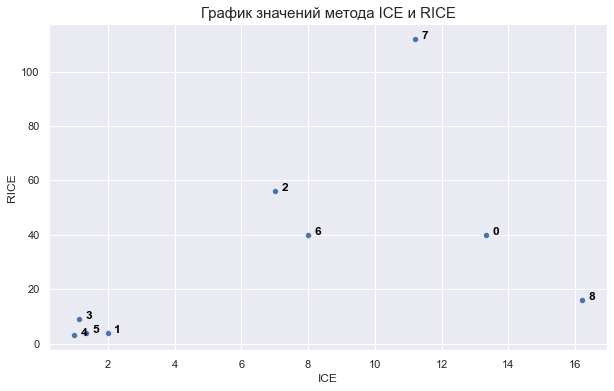

In [9]:
plt.figure(figsize=(10,6))
plt.title('График значений метода ICE и RICE', size=15)
sns.scatterplot(x=hypothesis['ICE'], y=hypothesis['RICE'])
for line in range(0,hypothesis.shape[0]):
     plt.text(hypothesis.ICE[line]+0.2, 
              hypothesis.RICE[line], 
              hypothesis.index[line], 
              horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show()


Исходя из графика можно сказать, что гипотезы 7, 2, 6, и 0 наиболее перспективные для обоих методов - ICE и RICE. При этом скопление гипотез 1, 3, 4, 5 внизу графика говорит об их низкой перспективности.

Видим, что состав наиболее перспективных гипотез по методу ICE и RICE практически не изменился, поменялась лишь приоритизация. Это произошло в основном из-за параметра reach. По методу RICE выбилась вперед гипотеза 7 с самым высоким параметром Reach - 10. Также по методу RICE среди перспективных появилась гипотеза 2 с высоким значением reach в 8 пунктов, хотя по оценке метода ICE она была на 5 месте. Параметр reach важен тем, что он помогает оценить охват пользователей, которых затронет изменение. Поэтому использование данного метода предпочтительней.


### Выводы

Наиболее перспективные гипотезы по методу ICE - 8, 0, 7 и 6:
    
* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Наиболее перспективные гипотезы по методу RICE - 7, 2, 0 и 6:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Состав наиболее перспективных гипотез по методу ICE и RICE практически не изменился, поменялась лишь приоритизация. Это произошло в основном из-за параметра reach. По методу RICE выбилась вперед гипотеза 7 с самым высоким параметром Reach - 10. Также по методу RICE среди перспективных появилась гипотеза 2 с высоким значением reach в 8 пунктов, хотя по оценке метода ICE она была на 5 месте. Параметр reach важен тем, что он помогает оценить охват пользователей, которых затронет изменение. Поэтому использование данного метода предпочтительней.

## Часть 2. Анализ A/B-теста

### Загрузка данных и подготовка к анализу

In [10]:
orders = pd.read_csv('../datasets/data_driven_decision_orders.csv')
visitors = pd.read_csv('../datasets/data_driven_decision_visitors.csv')

Выгрузим рандомно 5 строк из каждой таблицы чтобы ознакомиться с данными.

In [11]:
orders.sample(5)

,transactionId,visitorId,date,revenue,group
257,225225498,2308309101,2019-08-23,14271,A
994,2436452823,2710492161,2019-08-31,1460,B
1109,4215838417,399408949,2019-08-12,11490,A
546,2866469834,3917749921,2019-08-29,3950,B
899,2159858322,2283224496,2019-08-27,2180,A


In [12]:
visitors.sample(5)

,date,group,visitors
50,2019-08-20,B,560
57,2019-08-27,B,720
25,2019-08-26,A,722
54,2019-08-24,B,378
32,2019-08-02,B,581


In [13]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Видим, что пропущенных значений нет, но мы можем понизить разрядность столбца revenue для оптимизации работы кода, а также перевести date в формат даты.

In [14]:
orders['revenue'] = pd.to_numeric(orders['revenue'], downcast='signed')
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [15]:
print('Количество дубликатов:', orders.duplicated().sum())

Количество дубликатов: 0


Дубликатов при проверке не обнаружено.

In [16]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Видим, что пропущенных значений нет, но мы можем понизить разрядность столбца visitors для оптимизации работы кода, а также перевести date в формат даты.

In [17]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['visitors'] = pd.to_numeric(visitors['visitors'], downcast='signed')

In [18]:
print('Количество дубликатов:', visitors.duplicated().sum())

Количество дубликатов: 0


Дубликатов не обнаружено.

Проверим, есть ли в таблице orders пользователи, которые попали и в группу A, и в группу B.

In [19]:
group_counter = orders.groupby('visitorId')['group'].nunique()
gamaged_users = group_counter[group_counter > 1].index
print('Пользователи, попавшие в обе группы:', len(gamaged_users))

Пользователи, попавшие в обе группы: 58


Таких пользователей 58 во всем датасете. Удалим их из наших данных, поскольку они будут искажать проведение А/Б теста.

In [20]:
orders = orders[~orders['visitorId'].isin(gamaged_users)]

### Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

Создадим массив с уникальными парами значений дат и групп теста.

In [21]:
datesGroups = orders[['date', 'group']].drop_duplicates()

Получим агрегированные кумулятивные данные по дням о заказах.

In [22]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                                                    orders['group'] == x['group'])]\
                                    .agg({'date':'max', 'group':'max', 'transactionId':pd.Series.nunique,
                                         'visitorId':pd.Series.nunique, 'revenue':'sum'}), axis=1)\
                                    .sort_values(by=['date', 'group'])

Аналогично получим агрегированные кумулятивные данные по дням о посетителях магазина.

In [23]:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                        visitors['group'] == x['group'])]\
                                      .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)\
                                        .sort_values(by=['date', 'group'])

Объединим все кумулятивные данные в одну таблицу и переименуем названия столбцов.

In [24]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on = ['date', 'group'], 
                                        right_on = ['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Разделим данные на кумулятивной выручки по двум группам.

In [25]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders']]

Построим графики кумулятивной выручки по группам A и B.

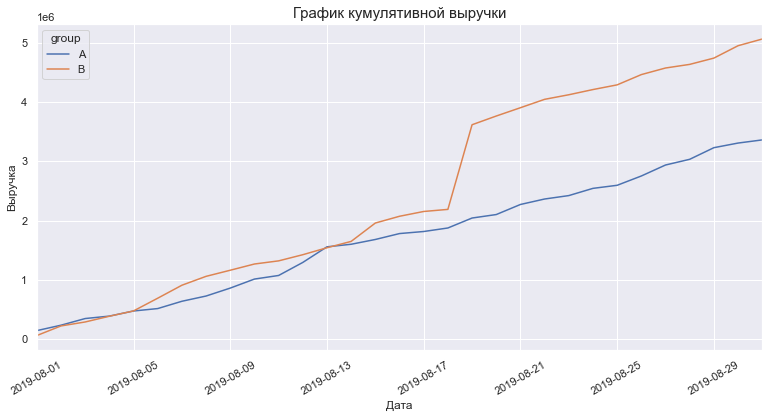

In [26]:
plt.figure(figsize = (13,6))
plt.title('График кумулятивной выручки',size=15)
sns.lineplot(data=cumulativeData, x='date', y='revenue', hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Выручка', size=12)
plt.xticks(rotation=30)
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00')) ###
plt.show()

Видим, что графики выручки на протяжении всего периода стабильно увеличиваются. Однако график выручки B резко возрастает на одном участке (18-19 августа), что может сигнализировать об аномальных значениях в данных (всплеск числа заказов, либо появление очень дорогих заказов в выборке).

### Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

Построим график среднего чека по группам.

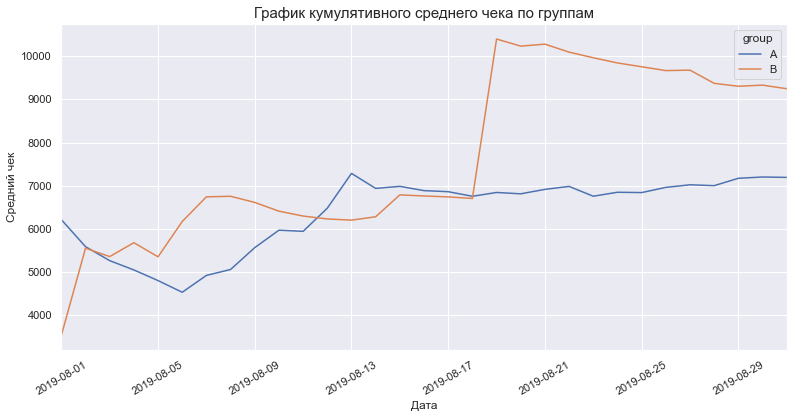

In [27]:
plt.figure(figsize=(13,6))
plt.title('График кумулятивного среднего чека по группам',size=15)
sns.lineplot(data=cumulativeData, x='date', y=cumulativeData['revenue']/cumulativeData['orders'], hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Cредний чек', size=12)
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.xticks(rotation=30)
plt.show()

По графику видим тенденцию роста среднего чека по группе A и B. Причем 13 августа 2019 года по группе B наблюдается резкий рост среднего чека по группе A. Предполагается наличие выбросов в этот момент времени (возможно нетипично дорогие заказы). По группе B наблюдаем резкий рост 19 августа 2019 года (опять же может быть из-за очень дорогих заказов), далее показатель выравнивается по обеим группам.

### Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

In [28]:
#Соберем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

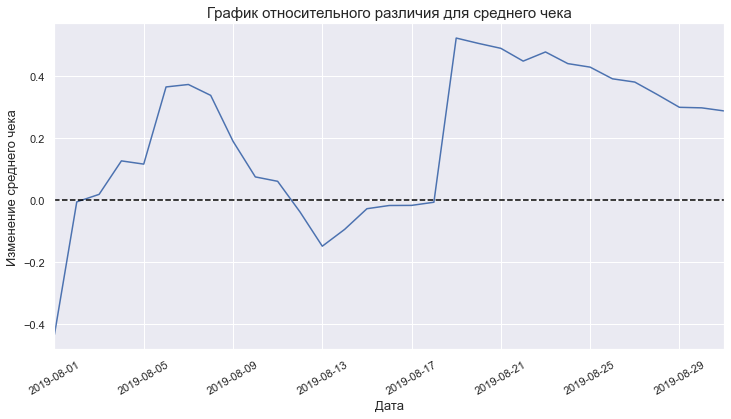

In [29]:
#Построим график относительного различия для среднего чека
plt.figure(figsize=(12, 6))
plt.title('График относительного различия для среднего чека', size=15)
sns.lineplot(data=mergedCumulativeRevenue, 
             x=mergedCumulativeRevenue['date'], 
             y=(mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])
             /(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=30)
plt.xlabel('Дата', size=13)
plt.ylabel('Изменение среднего чека', size=13)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.show()

В нескольких точках графика различия между средними чеками группы A и группы B "скачут", что свидетельствует о наличии выбросов в данных. Скорее всего в данных присутствуют крупные заказы, которые искажают картину по средним чекам.

### Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.

Посчитаем кумулятивную конверсию.

In [30]:
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']

#Конверсия по группе А
cumulativeDataA = cumulativeData[cumulativeData['group'] == 'A']
#Конверсия по группе B
cumulativeDataB = cumulativeData[cumulativeData['group'] == 'B']

Построим график кумулятивной конверсии.

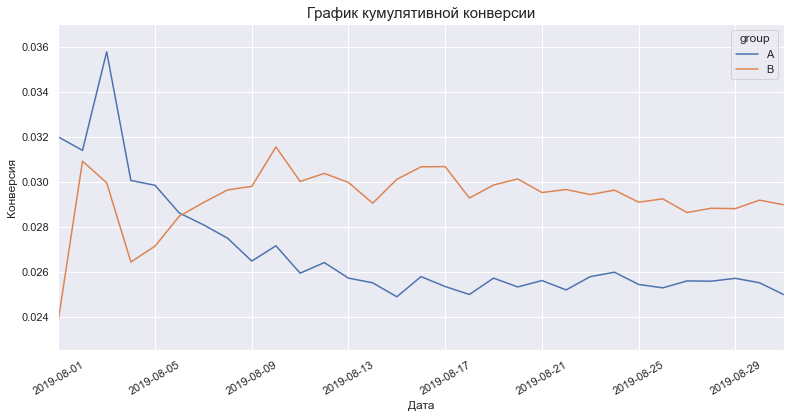

In [31]:
plt.figure(figsize = (13,6))
plt.title('График кумулятивной конверсии',size=15)
sns.lineplot(data=cumulativeData, x='date', y='conversion', hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Конверсия', size=12)
plt.xticks(rotation=30)
plt.axis(["2019-08-01", '2019-08-31', 0.0225, 0.037])
plt.show()

По графику видим, что в начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.029-0.030. 

### Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.

Объединим конверсии по группе A и группе B в одну таблицу.

In [32]:
mergedCumulativeConvesions = cumulativeDataA[['date', 'conversion']].merge(cumulativeDataB[['date', 'conversion']],
                                                                         left_on='date', right_on='date', how='left',
                                                                         suffixes=['A', 'B'])

Построим график относительного изменения кумулятивной конверсии группы B к группе A.

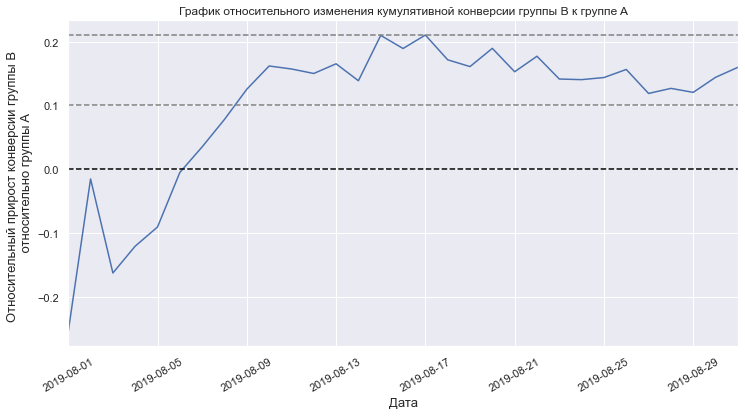

In [33]:
plt.figure(figsize=(12, 6))
plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
sns.lineplot(data=mergedCumulativeConvesions, x='date', 
             y=mergedCumulativeConvesions['conversionB']/mergedCumulativeConvesions['conversionA']-1)
plt.xticks(rotation=30)
plt.xlabel('Дата', size=13)
plt.ylabel('Относительный прирост конверсии группы B \n относительно группы A', size=13)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.21, color='grey', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.show()


В начале теста группа B проигрывала группе A, затем вырвалась вперед, и через какое-то время конверсия по группе B снова падала. Отношение конверсии еще не установилось на стабильном уровне (оно колеблется в диапазоне 0.1-0.21) и делать выводы о результате теста пока рано. Нужно анализировать аномалии.

### Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

Сгруппируем данные по посетителям сайта и посчитаем количество уникальных заказов по каждому пользователю.

In [34]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False)\
                 .agg({'transactionId':pd.Series.nunique}))

ordersByUsers.columns = ['visitorId', 'orders']

Построим гистограмму и точечный график количества заказов по пользователям для того чтобы проанализировать выбросы.

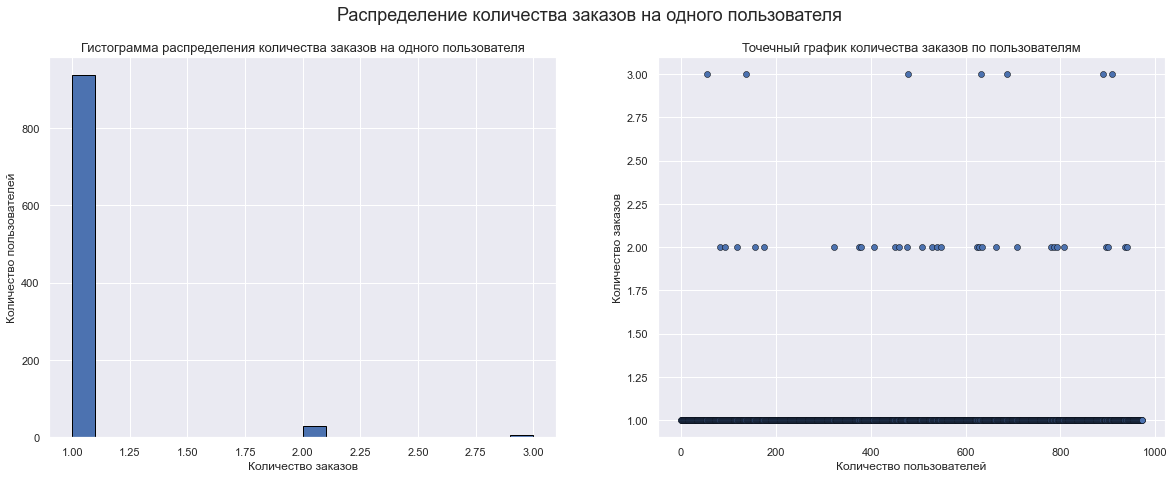

In [35]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
plt.suptitle('Распределение количества заказов на одного пользователя', size=18)

#Построение гистограммы
ordersByUsers['orders'].hist(bins=20, edgecolor='black', ax=axs[0])
axs[0].set_title('Гистограмма распределения количества заказов на одного пользователя', size=13)
axs[0].set_xlabel('Количество заказов')
axs[0].set_ylabel('Количество пользователей')

#Построение точечного графика
x_values = pd.Series(range(0,len(ordersByUsers)))
sns.scatterplot(x=x_values, y=ordersByUsers['orders'], edgecolor='black')
axs[1].set_title('Точечный график количества заказов по пользователям', size=13)
axs[1].set_xlabel('Количество пользователей')
axs[1].set_ylabel('Количество заказов')

plt.show()

По графикам видим, что наибольшее количество пользователей (около 800) совершили 1 покупку. Пользователей, которые совершили 2 покупки меньше - около 70. Все, что свыше 2-х покупок - скорее всего выбросы. 

### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

Посчитаем выборочные перцентили количества заказов на одного пользователя.

In [36]:
print('90, 95 и 99 перцентили:', np.percentile(ordersByUsers['orders'], [90, 95, 99]))

90, 95 и 99 перцентили: [1. 1. 2.]


Не более 5% пользователей оформляли больше двух заказов. И 10% пользователей заказывали более 1 раза.  Выберем 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеим аномальных пользователей по ней.

### Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

Построим гистограмму и точечный график распределения стоимостей заказов.

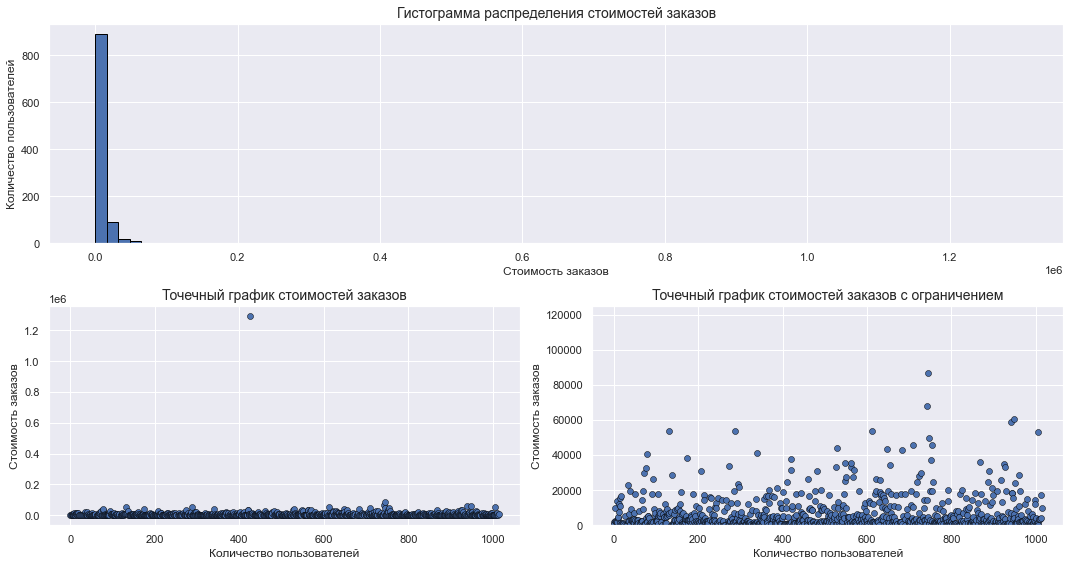

In [37]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(gs[0, :]) 
ax2 = fig.add_subplot(gs[1, 0]) 
ax3 = fig.add_subplot(gs[1, 1])


#Построение гистограммы
ax1.hist(orders['revenue'], bins=80, edgecolor='black')
ax1.set_title('Гистограмма распределения стоимостей заказов', fontsize=14)
ax1.set_xlabel('Cтоимость заказов')
ax1.set_ylabel('Количество пользователей')

#Построение точечного графика
x_values2 = pd.Series(range(0,len(orders['revenue'])))
sns.scatterplot(x=x_values2, y=orders['revenue'], edgecolor='black', ax=ax2)
ax2.set_title('Точечный график стоимостей заказов', size=14)
ax2.set_xlabel('Количество пользователей')
ax2.set_ylabel('Cтоимость заказов')

#Построение точечного графика c ограничением
sns.scatterplot(x=x_values2, y=orders['revenue'], edgecolor='black', ax=ax3)
ax3.set_title('Точечный график стоимостей заказов с ограничением', size=14)
ax3.set_xlabel('Количество пользователей')
ax3.set_ylabel('Cтоимость заказов')
ax3.set_ylim(0, 125000)


plt.tight_layout(pad=1)
plt.show()

По графикам видим, что больше всего пользователей совершало заказы со стоимостью ниже 40 000 руб. Можно предположить, что заказы свыше этой стоимости - выбросы. Для того чтобы проверить предположение посчитаем выборочные перцентили стоимости заказов на одного пользователя.

### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

Посчитаем выборочные перцентили стоимости заказов.

In [38]:
print('90, 95 и 99 перцентили:', np.percentile(orders['revenue'], [90, 95, 99]))

90, 95 и 99 перцентили: [17990. 26785. 53904.]


Не более 5% пользователей совершили покупки дороже 26 785 руб. и не более 1% дороже 53 904 руб. Пусть граница аномальных значений проходит в диапазоне свыше 26 785 руб.

### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.

In [39]:
#Найдем  количество посетителей в выбранную дату в группе A
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# Найдем количество посетителей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]\
                                            .agg({'date':'max', 'visitorsPerDateA':'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [40]:
#Найдем  количество посетителей в выбранную дату в группе B
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# Найдем количество посетителей до выбранной даты включительно в группе B
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]\
                                           .agg({'date':'max', 'visitorsPerDateB':'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [41]:
#Найдем количество и стоимость заказов по группе A
ordersADaily = (orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]\
                .groupby('date', as_index=False)\
                .agg({'transactionId':pd.Series.nunique, 'revenue':'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#Найдем количество и стоимость заказов по группе A до выбранной даты включительно
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]\
                                        .agg({'date':'max', 'ordersPerDateA':'sum', 'revenuePerDateA':'sum'}), 
                                        axis=1)\
                                        .sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [42]:
#Найдем количество и стоимость заказов по группе B
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]\
                .groupby('date', as_index=False)
                .agg({'transactionId':pd.Series.nunique, 'revenue':'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#Найдем количество и стоимость заказов по группе B до выбранной даты включительно
ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]\
                                        .agg({'date':'max', 'ordersPerDateB':'sum', 'revenuePerDateB':'sum'}), 
                                        axis=1)\
                                        .sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

Объединим все вычисленные параметры в одну таблицу.

In [43]:
ordersvisitorsMerge = (ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
                .merge(ordersACummulative, left_on='date', right_on='date', how='left')\
                .merge(ordersBCummulative, left_on='date', right_on='date', how='left')\
                .merge(visitorsADaily, left_on='date', right_on='date', how='left')\
                .merge(visitorsBDaily, left_on='date', right_on='date', how='left')\
                .merge(visitorsACummulative, left_on='date', right_on='date', how='left')\
                .merge(visitorsBCummulative, left_on='date', right_on='date', how='left'))

Создадим переменные ordersByUsersA и ordersByUsersB со столбцами 'visitorId', 'orders'. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [44]:
ordersByUsersA = (orders[orders['group'] == 'A']
                 .groupby('visitorId', as_index=False)
                    .agg({'transactionId':pd.Series.nunique}))
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B']
                 .groupby('visitorId', as_index=False)
                    .agg({'transactionId':pd.Series.nunique}))
ordersByUsersB.columns = ['visitorId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [45]:
sampleA = pd.concat([ordersByUsersA['orders'],
                    pd.Series(0, index=np.arange(ordersvisitorsMerge['visitorsPerDateA'].sum() 
                                                 - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],
                    pd.Series(0, index=np.arange(ordersvisitorsMerge['visitorsPerDateB'].sum()
                                                - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Проведем тест Манна-Уитни для проверки гипотезы о значимых различиях между сравниваемыми выборками. Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой. 

Также выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

<div style="border:solid #eaeaea 2px; padding: 15px">
Нулевая гипотеза H0 - значимые различия между сравниваемыми выборками отсутствуют
    
Альтернативная гипотеза H1 - значимые различия между сравниваемыми выборками есть 

Критический уровень статистической значимости: 
Alpha = 0.05</div>

In [46]:
print("p-value критерия Манна-Уитни: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print("Относительный прирост конверсии группы B: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value критерия Манна-Уитни: 0.011
Относительный прирост конверсии группы B: 0.160


p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 16%.

Этот результат мы получили по "сырым" данным.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию Манна-Уитни данные о выручке с заказов.

Также найдём относительные различия в среднем чеке между группами.

<div style="border:solid #eaeaea 2px; padding: 15px">
Нулевая гипотеза H0 - значимые различия между сравниваемыми выборками отсутствуют
    
Альтернативная гипотеза H1 - значимые различия между сравниваемыми выборками есть 

Критический уровень статистической значимости: 
Alpha = 0.05</div>

In [47]:
print('p-value критерия Манна-Уитни: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                                                        orders[orders['group']=='B']['revenue'],  
                                                                        alternative='two-sided')[1]))
print('Относительные различия в среднем чеке между группами: {0:.3f}'\
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value критерия Манна-Уитни: 0.829
Относительные различия в среднем чеке между группами: 0.287


В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.829, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу.

В результате проверки относительных различий в среднем чеке получили, что средний чек группы B почти на 28.7% выше среднего чека группы A.

Данные результаты были получены на "сырых" данных. Необходимо избавиться от аномалий в данных.

### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.

На предыдущих шагах мы получили, что:

<div style="border:solid #eaeaea 2px; padding: 15px">
Не более 5% пользователей оформляли больше двух заказов. И 10% пользователей заказывали более 1 раза.  Выберем 2 заказа на одного пользователя за нижнюю границу числа заказов, и отсеим аномальных пользователей по ней.

    
Не более 5% пользователей совершили покупки дороже 26 785 руб. и не более 1% дороже 53 904 руб. Пусть граница аномальных значений проходит в диапазоне свыше 26 785 руб.
</div>

Примем за аномальных пользователей тех, кто совершил от 2 заказов или совершил заказ дороже 32 000 рублей. Так мы уберём 5% пользователей с наибольшим числом заказов и от 1% до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 32 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

Узнаем, сколько всего аномальных пользователей методом shape()

In [48]:
#Посетители с аномальным количеством заказов
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis=0)

usersWithExpensiveOrders = orders[orders['revenue'] > 26785]['visitorId']
abnormalUsers = (pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
                .drop_duplicates()
                .sort_values())
print('Количество аномальных пользователей:', abnormalUsers.shape)

Количество аномальных пользователей: (58,)


Всего 58 аномальных посетителей. 
Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [49]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                            pd.Series(0, index=np.arange(ordersvisitorsMerge['visitorsPerDateA'].sum()
                                                        - len(ordersByUsersA['orders'])), name='orders')], axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                            pd.Series(0, index=np.arange(ordersvisitorsMerge['visitorsPerDateB'].sum()
                                                        - len(ordersByUsersB['orders'])), name='orders')], axis=0)

Применим критерий Манна-Уитни.

<div style="border:solid #eaeaea 2px; padding: 15px">
Нулевая гипотеза H0 - значимые различия между сравниваемыми выборками отсутствуют
    
Альтернативная гипотеза H1 - значимые различия между сравниваемыми выборками есть 

Критический уровень статистической значимости: 
Alpha = 0.05</div>

In [50]:
print('p-value критерия Манна-Уитни: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, 
                                                                        alternative='two-sided')[1]))
print('Относительный прирост конверсии группы B: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value критерия Манна-Уитни: 0.012
Относительный прирост конверсии группы B: 0.182


p-value = 0.012 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 18.2%.

Результаты теста Манна-Уитни по очищенным данным в отошении конверсии практически не изменились.

### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

Применим критерий Манна-Уитни для подсчета статистической значимости различий в среднем чеке заказа между группами по очищенным данным.

<div style="border:solid #eaeaea 2px; padding: 15px">
Нулевая гипотеза H0 - значимые различия между сравниваемыми выборками отсутствуют
    
Альтернативная гипотеза H1 - значимые различия между сравниваемыми выборками есть 

Критический уровень статистической значимости: 
Alpha = 0.05</div>

In [51]:
print('p-value критерия Манна-Уитни: {0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', 
                                                                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                                                               )]['revenue'], 
                                          orders[np.logical_and(orders['group']=='B',
                                                               np.logical_not(orders['visitorId'].isin(abnormalUsers)))
                                                ]['revenue'], alternative='two-sided')[1]))
print('Относительные различия в среднем чеке между группами: {0:.3f}'\
      .format(orders[np.logical_and(orders['group']=='B', 
                                             np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
                      / orders[np.logical_and(orders['group']=='A',
                                             np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()
                      -1))

p-value критерия Манна-Уитни: 0.646
Относительные различия в среднем чеке между группами: -0.048


p-value увеличился по сравнению с результатом, полученным на сырых данных. В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.646, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу.

При этом разница между сегментами сократилась с 29% до 5%.


### Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

Произведем чистку данных от аномальных значений, 

In [52]:
orders_filtered = orders.loc[~(orders['revenue'] > 26785),:]
ordersByUsers_filtered = ordersByUsers[ordersByUsers['orders'] < 2]
orders_filtered = orders_filtered[orders_filtered['visitorId'].isin(ordersByUsers_filtered['visitorId'])]


In [53]:
#Массив с уникальными парами значений дат и групп теста.
datesGroups_filtered = orders_filtered[['date', 'group']].drop_duplicates()

#агрегированные кумулятивные данные по дням о заказах
ordersAggregated_filtered = datesGroups_filtered.apply(lambda x:
                                                       orders_filtered[np.logical_and(\
                                                           orders_filtered['date'] <= x['date'],
                                                                    orders_filtered['group'] == x['group'])]\
                                    .agg({'date':'max', 'group':'max', 'transactionId':pd.Series.nunique,
                                         'visitorId':pd.Series.nunique, 'revenue':'sum'}), axis=1)\
                                    .sort_values(by=['date', 'group'])

#агрегированные кумулятивные данные по дням о посетителях магазина.
visitorsAggregated_filtered = datesGroups_filtered.apply(lambda x: 
                                                visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                        visitors['group'] == x['group'])]\
                                      .agg({'date':'max', 'group':'max', 'visitors':'sum'}), axis=1)\
                                        .sort_values(by=['date', 'group'])

#Объединение агрегированных кумулятивных данных
cumulativeData_filtered = ordersAggregated_filtered.merge(visitorsAggregated_filtered, 
                                                          left_on = ['date', 'group'], 
                                                        right_on = ['date', 'group'])
cumulativeData_filtered.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

Построим график кумулятивной выручки по очищенным данным.

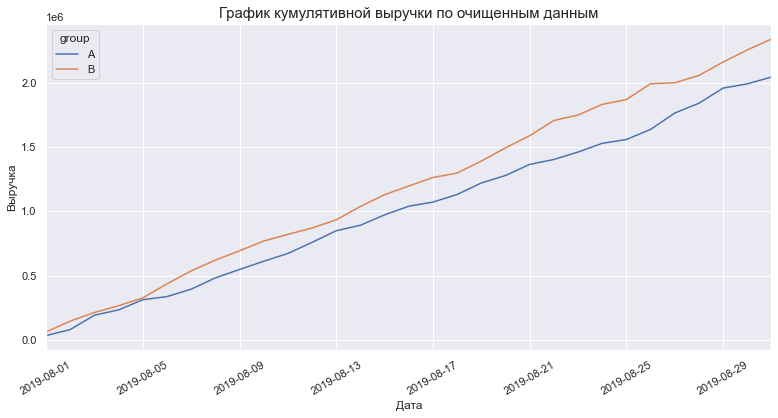

In [54]:
plt.figure(figsize = (13,6))
plt.title('График кумулятивной выручки по очищенным данным',size=15)
sns.lineplot(data=cumulativeData_filtered, x='date', y='revenue', hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Выручка', size=12)
plt.xticks(rotation=30)
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.show()

По графику кумулятивной выручки по очищенным данным видим, что выручка групп A и B была примерно одинаковой вплоть до 5 августа, затем выручка по группе B стала выше кумулятивной выручки по группе A и сохранила такой результат до конца рассматриваемого периода.

Построим график кумулятивного среднего чека по группам по очищенным данным.

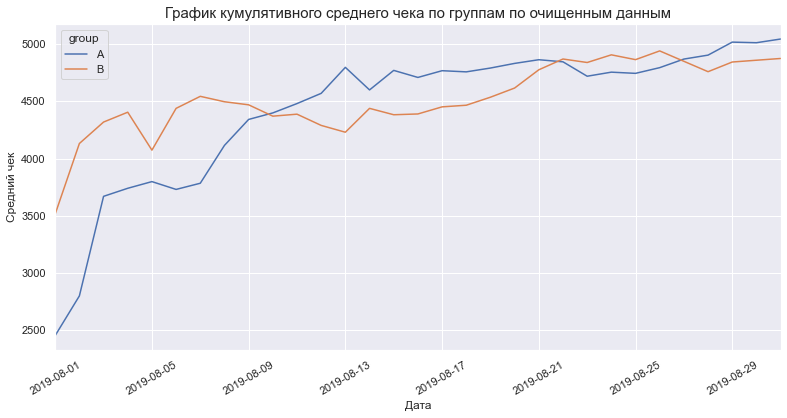

In [55]:
plt.figure(figsize=(13,6))
plt.title('График кумулятивного среднего чека по группам по очищенным данным', size=15)
sns.lineplot(data=cumulativeData_filtered, x='date', 
             y=cumulativeData_filtered['revenue']/cumulativeData_filtered['orders'], hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Cредний чек', size=12)
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.xticks(rotation=30)
plt.show()

По графику видим, что средний чек по группе B в начале исследования был выше среднего чека по группе A, затем в период с 3 августа по 12 августа стал ниже среднего чека группы A. В период с 14 по 30 августа средние чеки по обеим группам незначительно колебались в диапазоне 4500-5000 рублей. Сильных различий в значениях средних чеков по обеим группам не наблюдается.

Разделим данные на кумулятивной выручки по двум группам.

In [56]:
cumulativeRevenueA_filtered = cumulativeData_filtered[\
    cumulativeData_filtered['group'] == 'A'][['date', 'revenue', 'orders']]
cumulativeRevenueB_filtered = cumulativeData_filtered[\
    cumulativeData_filtered['group'] == 'B'][['date', 'revenue', 'orders']]

In [57]:
#Соберем данные в одном датафрейме
mergedCumulativeRevenue_filtered = cumulativeRevenueA_filtered.merge(cumulativeRevenueB_filtered, 
                                                                     left_on='date', right_on='date', 
                                                                       how='left', suffixes=['A', 'B'])

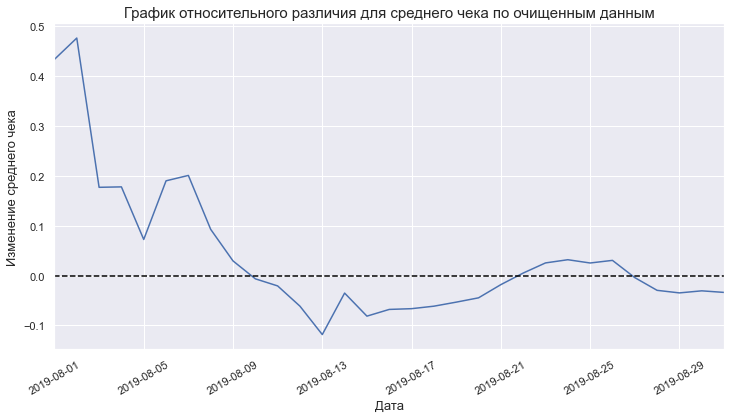

In [58]:
#Построим график относительного различия для среднего чека
plt.figure(figsize=(12, 6))
plt.title('График относительного различия для среднего чека по очищенным данным', size=15)
sns.lineplot(data=mergedCumulativeRevenue_filtered, 
             x=mergedCumulativeRevenue_filtered['date'], 
             y=(mergedCumulativeRevenue_filtered['revenueB']/mergedCumulativeRevenue_filtered['ordersB'])
             /(mergedCumulativeRevenue_filtered['revenueA']/mergedCumulativeRevenue_filtered['ordersA'])-1)
plt.xticks(rotation=30)
plt.xlabel('Дата', size=13)
plt.ylabel('Изменение среднего чека', size=13)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.show()

После чистки данных от выбросов мы видим, что сильные различия в чеках наблюдались в начале расматриваемого периода вплоть до 13 августа, затем обе группы сравнялись и наблюдались незначительные различия в средних чеках.

In [59]:
#Посчитаем кумулятивную конверсию.
cumulativeData_filtered['conversion'] = cumulativeData_filtered['orders'] / cumulativeData_filtered['visitors']

#Конверсия по группе А
cumulativeDataA_filtered = cumulativeData_filtered[cumulativeData_filtered['group'] == 'A']
#Конверсия по группе B
cumulativeDataB_filtered = cumulativeData_filtered[cumulativeData_filtered['group'] == 'B']

Построим график кумулятивной конверсии по очищенным данным.

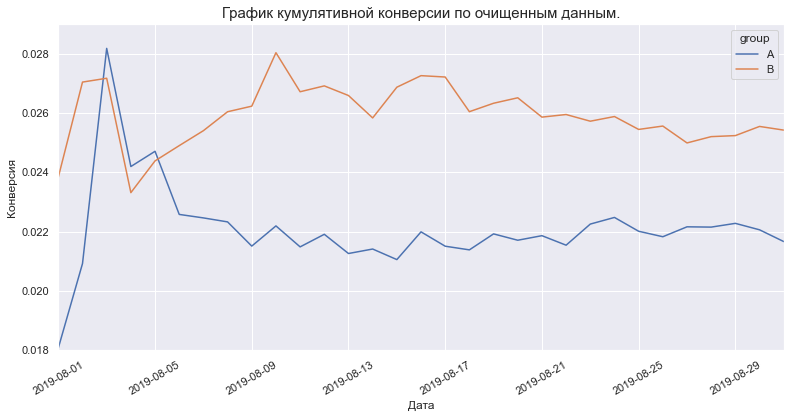

In [60]:
plt.figure(figsize = (13,6))
plt.title('График кумулятивной конверсии по очищенным данным.',size=15)
sns.lineplot(data=cumulativeData_filtered, x='date', y='conversion', hue='group')
plt.xlabel('Дата', size=12)
plt.ylabel('Конверсия', size=12)
plt.xticks(rotation=30)
plt.axis(["2019-08-01", '2019-08-31', 0.018, 0.029])
plt.show()

По графику видим, что в начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.025-0.028. Конверсия по очищенным данным не сильно отличается от конверсии по сырым данным.

Объединим конверсии по группе A и группе B в одну таблицу.

In [61]:
mergedCumulativeConvesions_filtered = cumulativeDataA_filtered[['date', 'conversion']].merge(
    cumulativeDataB_filtered[['date', 'conversion']], left_on='date', right_on='date', how='left',
                                                                         suffixes=['A', 'B'])

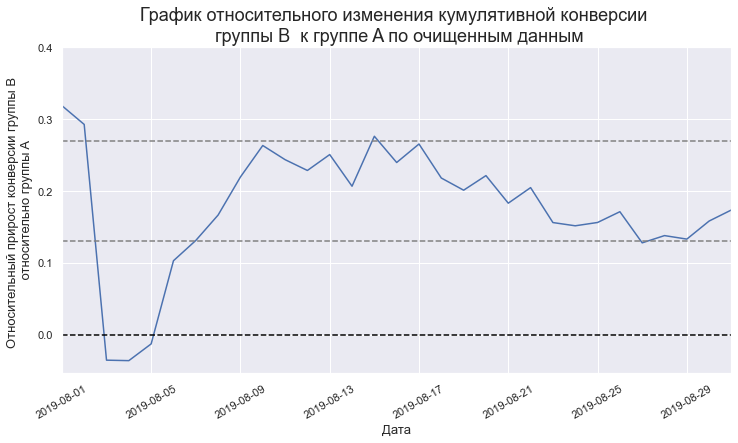

In [62]:
#Построим график относительного изменения кумулятивной конверсии группы B к группе A.

plt.figure(figsize=(12, 6))
plt.title('График относительного изменения кумулятивной конверсии \n группы B  к группе A по очищенным данным', size=18)
sns.lineplot(data=mergedCumulativeConvesions_filtered, x='date', 
             y=mergedCumulativeConvesions_filtered['conversionB']/mergedCumulativeConvesions_filtered['conversionA']-1)
plt.xticks(rotation=30)
plt.xlabel('Дата', size=13)
plt.ylabel('Относительный прирост конверсии группы B \n относительно группы A', size=13)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.27, color='grey', linestyle='--')
plt.axhline(y=0.13, color='grey', linestyle='--')
plt.xlim(np.datetime64('2019-08-01 00:00:00'), np.datetime64('2019-08-31 00:00:00'))
plt.ylim(None, 0.4)
plt.show()


У группы B конверсия выше и относительный прирост конверсии в период с 8 августа до окончания теста колебался в диапазоне 0,13-0,27.

<div style="border:solid #eaeaea 2px; padding: 15px">
По результатам теста было принято решение остановить тест, зафиксировать победу группы B. Несмотря на то, что значимых различий среднего чека между двумя группами не наблюдается, у группы B выше конверсия, а значит мы успешно привлекаем и удерживаем пользователей. В долгосрочной перспективе это поможет сформировать стек лояльных постоянных покупателей, что приведет к стабильному росту выручки. 
Продолжать тест смысла нет, поскольку мы получили интерпретируемый результат и увидели влияние изменений на выручку и конверсию.
</div>

### Выводы

**Анализ датафрейма по сырым данным показал, что:**


* Выручка на протяжении всего периода стабильно увеличивается. Выручка группы B резко возрастает на одном участке (18-19 августа), что может сигнализировать об аномальных значениях в данных (всплеск числа заказов, либо появление очень дорогих заказов в выборке).


* Наблюдается тенденция роста среднего чека по группе A и B. Причем 13 августа 2019 года по группе B наблюдается резкий рост среднего чека по группе A. Предполагается наличие выбросов в этот момент времени (возможно нетипично дорогие заказы). По группе B наблюдается резкий рост 19 августа 2019 года (опять же может быть из-за очень дорогих заказов), далее показатель выравнивается по обеим группам.


* Различия между средними чеками группы A и группы B "скачут", что свидетельствует о наличии выбросов. Скорее всего в данных присутствуют крупные заказы, которые искажают картину по средним чекам.


* В начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.029-0.030. 


* Наибольшее количество пользователей (около 800) совершили 1 покупку. Пользователей, которые совершили 2 покупки меньше - около 70. Все, что свыше 2-х покупок - выбросы.


* Не более 5% пользователей оформляли больше двух заказов. И 10% пользователей заказывали более 1 раза. 


* Больше всего пользователей совершало заказы со стоимостью ниже 50 000 руб


* Не более 5% пользователей совершили покупки дороже 26 785 руб. и не более 1% дороже 53 904 руб. Пусть граница аномальных значений проходит в диапазоне свыше 26 785 руб.

**Анализ датафрейма по очищенным данным показал, что:**


* Выручка групп A и B была примерно одинаковой вплоть до 5 августа, затем выручка по группе B стала выше кумулятивной выручки по группе A и сохранила такой результат до конца рассматриваемого периода.


* Средний чек по группе B в начале исследования был выше среднего чека по группе A, затем в период с 3 августа по 12 августа стал ниже среднего чека группы A. В период с 14 по 30 августа средние чеки по обеим группам незначительно колебались в диапазоне 4500-5000 рублей. Сильных различий в значениях средних чеков по обеим группам не наблюдается.


* После чистки данных от выбросов мы видим, что сильные различия в чеках наблюдались в начале расматриваемого периода вплоть до 13 августа, затем обе группы сравнялись и наблюдались незначительные различия в средних чеках.


* По графику видим, что в начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.025-0.028. Конверсия по очищенным данным не сильно отличается от конверсии по сырым данным.


* У группы B конверсия выше и относительный прирост конверсии в период с 8 августа до окончания теста колебался в диапазоне 0,13-0,27.


**Результаты тестирования гипотез на сырых данных:**


* p-value = 0.011 по критерию Манна-Уитни меньше критического уровня статистической значимости 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 16%.


* В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.829, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу о том, что статистически значимых различий между группами нет.


* В результате проверки относительных различий в среднем чеке получили, что средний чек группы B почти на 28.7% выше среднего чека группы A.

**Результаты тестирования гипотез на очищенных данных:**


* Всего 58 аномальных посетителей. Мы приняли за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 26 785 рублей. 


* p-value = 0.012 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 18.2%.


* Результаты теста Манна-Уитни по очищенным данным в отошении конверсии практически не изменились.


* p-value увеличился по сравнению с результатом, полученным на сырых данных. В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.646, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу.

При этом разница между сегментами сократилась с 29% до 5%.


*По результатам теста было принято решение остановить тест, зафиксировать победу группы B. Несмотря на то, что значимых различий среднего чека между двумя группами не наблюдается, у группы B выше конверсия, а значит мы успешно привлекаем и удерживаем пользователей. В долгосрочной перспективе это поможет сформировать стек лояльных постоянных покупателей, что приведет к стабильному росту выручки. Продолжать тест смысла нет, поскольку мы получили интерпретируемый результат и увидели влияние изменений на выручку и конверсию.*

## Выводы

***Приоритизация гипотез***

Наиболее перспективные гипотезы по методу ICE - 8, 0, 7 и 6:
    
* Запустить акцию, дающую скидку на товар в день рождения
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Наиболее перспективные гипотезы по методу RICE - 7, 2, 0 и 6:

* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Состав наиболее перспективных гипотез по методу ICE и RICE практически не изменился, поменялась лишь приоритизация. Это произошло в основном из-за параметра reach. По методу RICE выбилась вперед гипотеза 7 с самым высоким параметром Reach - 10. Также по методу RICE среди перспективных появилась гипотеза 2 с высоким значением reach в 8 пунктов, хотя по оценке метода ICE она была на 5 месте. Параметр reach важен тем, что он помогает оценить охват пользователей, которых затронет изменение. Поэтому использование данного метода предпочтительней.

***Анализ A/B-теста***

**Анализ датафрейма по сырым данным показал, что:**


* Выручка на протяжении всего периода стабильно увеличивается. Выручка группы B резко возрастает на одном участке (18-19 августа), что может сигнализировать об аномальных значениях в данных (всплеск числа заказов, либо появление очень дорогих заказов в выборке).


* Наблюдается тенденция роста среднего чека по группе A и B. Причем 13 августа 2019 года по группе B наблюдается резкий рост среднего чека по группе A. Предполагается наличие выбросов в этот момент времени (возможно нетипично дорогие заказы). По группе B наблюдается резкий рост 19 августа 2019 года (опять же может быть из-за очень дорогих заказов), далее показатель выравнивается по обеим группам.


* Различия между средними чеками группы A и группы B "скачут", что свидетельствует о наличии выбросов. Скорее всего в данных присутствуют крупные заказы, которые искажают картину по средним чекам.


* В начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.029-0.030. 


* Наибольшее количество пользователей (около 800) совершили 1 покупку. Пользователей, которые совершили 2 покупки меньше - около 70. Все, что свыше 2-х покупок - выбросы.


* Не более 5% пользователей оформляли больше двух заказов. И 10% пользователей заказывали более 1 раза. 


* Больше всего пользователей совершало заказы со стоимостью ниже 50 000 руб


* Не более 5% пользователей совершили покупки дороже 26 785 руб. и не более 1% дороже 53 904 руб. Пусть граница аномальных значений проходит в диапазоне свыше 26 785 руб.

**Анализ датафрейма по очищенным данным показал, что:**


* Выручка групп A и B была примерно одинаковой вплоть до 5 августа, затем выручка по группе B стала выше кумулятивной выручки по группе A и сохранила такой результат до конца рассматриваемого периода.


* Средний чек по группе B в начале исследования был выше среднего чека по группе A, затем в период с 3 августа по 12 августа стал ниже среднего чека группы A. В период с 14 по 30 августа средние чеки по обеим группам незначительно колебались в диапазоне 4500-5000 рублей. Сильных различий в значениях средних чеков по обеим группам не наблюдается.


* После чистки данных от выбросов мы видим, что сильные различия в чеках наблюдались в начале расматриваемого периода вплоть до 13 августа, затем обе группы сравнялись и наблюдались незначительные различия в средних чеках.


* По графику видим, что в начале эксперимента конверсия группы A была выше конверсии групы B, но тендеция роста была схожей, затем после 6 августа 2019 года конверсия группы B стала сильно больше,а конверсия группы A просела. Конверсия группы B колебалась в диапазоне 0.025-0.028. Конверсия по очищенным данным не сильно отличается от конверсии по сырым данным.


* У группы B конверсия выше и относительный прирост конверсии в период с 8 августа до окончания теста колебался в диапазоне 0,13-0,27.


**Результаты тестирования гипотез на сырых данных:**


* p-value = 0.011 по критерию Манна-Уитни меньше критического уровня статистической значимости 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 16%.


* В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.829, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу о том, что статистически значимых различий между группами нет.


* В результате проверки относительных различий в среднем чеке получили, что средний чек группы B почти на 28.7% выше среднего чека группы A.

**Результаты тестирования гипотез на очищенных данных:**


* Всего 58 аномальных посетителей. Мы приняли за аномальных пользователей тех, кто совершил больше 2 заказов или совершил заказ дороже 26 785 рублей. 


* p-value = 0.012 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем и не отвергаем альтернативную гипотезу - значимые различия между сравниваемыми выборками есть. Относительный выигрыш группы B - 18.2%.


* Результаты теста Манна-Уитни по очищенным данным в отошении конверсии практически не изменились.


* p-value увеличился по сравнению с результатом, полученным на сырых данных. В результате проверки гипотезы о значимых различиях между сравниваемыми выборками среднего чека получили p-value=0.646, что значительно выше критического уровня статистической значимости 5%, а значит мы не отвергаем нулевую гипотезу.

При этом разница между сегментами сократилась с 29% до 5%.


*По результатам теста было принято решение остановить тест, зафиксировать победу группы B. Несмотря на то, что значимых различий среднего чека между двумя группами не наблюдается, у группы B выше конверсия, а значит мы успешно привлекаем и удерживаем пользователей. В долгосрочной перспективе это поможет сформировать стек лояльных постоянных покупателей, что приведет к стабильному росту выручки. Продолжать тест смысла нет, поскольку мы получили интерпретируемый результат и увидели влияние изменений на выручку и конверсию.*